# Post-Processing Textract with Location-Aware Transformers

**LayoutLM** is a BERT-like language model architecture in which the *position embedding* inputs (usually encoding the position of each word/token in the input sequence, as discussed in more detail in [this paper](https://openreview.net/forum?id=onxoVA9FxMw)) are modified to encode the **absolute position of the word/token on a page**.

Architectures like this enable us to build models which are aware of both *language* and *page position*: perfect for analyzing and post-processing OCR results from services like [Amazon Textract](https://aws.amazon.com/textract/), which returns both the detected text and the location of each word in the input document.

Since LayoutLM is based on a standard multi-task text transformer architecture with customizations to the input processing layer, this approach could be generalized to a wide range of task types using both text and position information, like:

- "Self-supervised" pre-training on Textracted but otherwise unlabelled documents
- Document/page/sequence classification
- Entity extraction (token/word classification)
- Span extraction and extractive question answering
- "Translation", generative question answering or other sequence generation

Some of these use cases (notably pre-training, sequence classification and token/word classification) are already supported in the LayoutLM implementation provided in the popular [HuggingFace Transformers library](https://huggingface.co/transformers/model_doc/layoutlm.html).

In this notebook, we demonstrate token/word classification to extract key elements on a use case where Textract's built-in Key-Value "Forms" functionality helps with some examples but misses others due to the structure of the document.

For more information, check out:

- The [LayoutLM paper (2019, Xu et al)](https://arxiv.org/abs/1912.13318)
- The [originally released source code](https://github.com/microsoft/unilm/tree/master/layoutlm)

## Getting started: Dependencies and configuration

First there are some additional libraries we need to install:

In [1]:
# Base library for the model:
!pip install transformers

  Using cached transformers-4.3.2-py3-none-any.whl (1.8 MB)
Processing /root/.cache/pip/wheels/69/09/d1/bf058f7d6fa0ecba2ce7c66be3b8d012beb4bf61a6e0c101c0/sacremoses-0.0.43-py3-none-any.whl
  Using cached regex-2020.11.13-cp37-cp37m-manylinux2014_x86_64.whl (719 kB)
     |████████████████████████████████| 3.2 MB 6.0 MB/s eta 0:00:01


In [123]:
# Utility for running docs through Textract:
!git clone https://github.com/athewsey/amazon-textract-textractor.git textractor
!git checkout feat/betterio
!pip install -r textractor/src/requirements.txt

Cloning into 'textractor'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 101 (delta 17), reused 24 (delta 11), pack-reused 59
Receiving objects: 100% (101/101), 123.85 KiB | 15.48 MiB/s, done.
Resolving deltas: 100% (36/36), done.


In [2]:
# Tool for splitting PDFs into SMGT-ready images:
!conda install -c conda-forge poppler -y
!pip install pdf2image

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.2
  latest version: 4.9.2

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - poppler


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.11.28         |           py37_0         148 KB  conda-forge
    conda-4.9.2                |   py37h89c1867_0         3.0 MB  conda-forge
    openjpeg-2.3.1             |       h981e76c_3         475 KB  conda-forge
    poppler-0.65.0             |       h581218d_1         1.3 MB
    poppler-data-0.4.10        |                0         3

With the requried libraries installed, we're ready to import dependencies and set up bucket paths/etc.

In [88]:
# Python Built-Ins:
from collections import defaultdict
from functools import reduce
import json
import os
import random
import shutil
import sys
import time
from types import SimpleNamespace

# External Dependencies:
import boto3
from botocore import exceptions as botoexceptions
from matplotlib import pyplot as plt
import pandas as pd
import pdf2image
import PIL
from PIL import ExifTags
import sagemaker
from tqdm import tqdm_notebook

# Local Dependencies:
from textractor.src import trp

bucket_name = # TODO?
prefix = "receipts"

raw_prefix = f"{prefix}/raw"
raw_path = "data/raw"
textract_clean_path = "data/textract-results-clean"
textract_clean_prefix = f"{prefix}/textract-results-clean"

bucket = boto3.resource("s3").Bucket(bucket_name)
smclient = boto3.client("sagemaker")

role = sagemaker.get_execution_role()

## Data Preparation

### Sanitize Input Documents

- We want to annotate pages with bounding boxes, so will need to split PDFs into images
- EXIF rotations will not be applied to images in SageMaker Ground Truth (at least in Firefox?) so need to translate these

In [128]:
os.makedirs("data", exist_ok=True)
!aws s3 sync --quiet s3://$bucket_name/$raw_prefix ./$raw_path

In [37]:
def split_filename(filename):
    basename, _, ext = filename.rpartition(".")
    return basename, ext

def clean_dataset_for_imgocr(
    from_path,
    to_path,
    pdf_dpi=300,
    pdf_image_format="png",
    textract_compatible_formats=("jpg", "jpeg", "png"),
    preferred_image_format="png",
):
    results = []  # TODO: Add
    # Pre-calculate the list of input file paths so we can show a progress bar:
    filepaths = list(filter(
        lambda path: "/." not in path,  # Ignore hidden files/folders e.g. .ipynb_checkpoints
        (os.path.join(path, f) for path, _, files in os.walk(from_path) for f in files)
    ))
    n_files_total = len(filepaths)
    
    for filepath in tqdm_notebook(filepaths, desc="Processing input files...", unit="file"):
        filename = os.path.basename(filepath)
        subfolder = os.path.dirname(filepath)[len(from_path):] # Includes leading slash!
        outfolder = to_path + subfolder
        os.makedirs(outfolder, exist_ok=True)
        basename, ext = split_filename(filename)
        ext_lower = ext.lower()
        result = SimpleNamespace(
            rawpath=filepath,
            cleanpaths=[],
            cats=subfolder[1:].split(os.path.sep) # Strip leading slash to avoid initial ''
        )
        if ext_lower == "pdf":
            print("Converting {} to {}/{}*.{}".format(
                filepath,
                outfolder,
                basename + "-",
                pdf_image_format,
            ))
            images = pdf2image.convert_from_path(
                filepath,
                output_folder=outfolder,
                output_file=basename + "-",
                fmt=pdf_image_format,
                dpi=pdf_dpi,
            )
            result.cleanpaths = [i.filename for i in images]
            results.append(result)
            print("* PDF converted {}:\n    - {}".format(
                filepath,
                "\n    - ".join(result.cleanpaths),
            ))
        else:
            try:
                image = PIL.Image.open(filepath)
            except PIL.UnidentifiedImageError:
                print(f"* Ignoring incompatible file: {filepath}")
                continue

            # Correct orientation from EXIF data:
            for orientation in ExifTags.TAGS.keys() : 
                if ExifTags.TAGS[orientation]=="Orientation":
                    break
            exif = dict((image._getexif() or {}).items())
            img_orientation = exif.get(orientation)
            print("Image {} has orientation {}".format(filepath, img_orientation))
            if img_orientation == 3:
                image = image.rotate(180, expand=True)
                rotated = True
            elif img_orientation == 6:
                image = image.rotate(270, expand=True)
                rotated = True
            elif img_orientation == 8:
                image = image.rotate(90, expand=True)
                rotated = True
            else:
                rotated = False

            if ext_lower not in textract_compatible_formats:
                outpath = os.path.join(outfolder, f"{basename}.{preferred_image_format}")
                image.save(outpath)
                print(f"* Converted image {filepath} to {outpath}")
            elif rotated:
                outpath = os.path.join(outfolder, filename)
                image.save(outpath)
                print(f"* Rotated image {filepath} to {outpath}")
            else:
                outpath = os.path.join(outfolder, filename)
                
                shutil.copy2(filepath, outpath)
                print(f"* Copied file {filepath} to {outpath}")
            result.cleanpaths = [outpath]
            results.append(result)

    print("Done!")
    return results

cleanimg_path = "data/images-cleaned"
!rm -rf cleanimg_path
time.sleep(5)  # Give EFS a little time to catch up
clean_results = clean_dataset_for_imgocr(raw_path, cleanimg_path)

Image data/raw/original/X51006619346.jpg has orientation None
* Copied file data/raw/original/X51006619346.jpg to data/images-cleaned/original/X51006619346.jpg
Image data/raw/original/X51006555833.jpg has orientation None
* Copied file data/raw/original/X51006555833.jpg to data/images-cleaned/original/X51006555833.jpg
Image data/raw/original/X51005577191.jpg has orientation None
* Copied file data/raw/original/X51005577191.jpg to data/images-cleaned/original/X51005577191.jpg
Image data/raw/original/X51006857540.jpg has orientation None
* Copied file data/raw/original/X51006857540.jpg to data/images-cleaned/original/X51006857540.jpg
Image data/raw/original/X51006334766.jpg has orientation None
* Copied file data/raw/original/X51006334766.jpg to data/images-cleaned/original/X51006334766.jpg
Image data/raw/original/X51006327953.jpg has orientation None
* Copied file data/raw/original/X51006327953.jpg to data/images-cleaned/original/X51006327953.jpg
Image data/raw/original/X51005806718.jpg

In [42]:
def total_output_files(results):
    return reduce(lambda acc, r: acc + len(r.cleanpaths), results, 0)

print("Processed {} input files to {} output files".format(
    len(clean_results),
    total_output_files(clean_results),
))
topcat_results = defaultdict(list)
for r in clean_results:
    # TODO: Change back to 0
    topcat_results[r.cats[0]].append(r)

print({ k: total_output_files(topcat_results[k]) for k in topcat_results})

Processed 372 input files to 372 output files
{'original': 347, 'custom': 25}


In [23]:
# raw_path = "data/raw"
# cleanimg_path = "data/images-cleaned"

# # PDF conversion:
# PDF_DPI = 300
# PDF_IMAGE_FORMAT = "png"
# # Textract-incompatible image conversion:
# TEXTRACT_COMPATIBLE_IMAGE_FORMATS = ("jpg", "jpeg", "png")
# PREFERRED_IMAGE_FORMAT = "png"

# for currpath, dirs, files in os.walk(raw_path):
#     for filename in files:
#         filepath = os.path.join(currpath, filename)
#         subfolder = currpath[len(raw_path):]
#         outfolder = cleanimg_path + subfolder
#         os.makedirs(outfolder, exist_ok=True)
#         basename, _, ext = filename.rpartition(".")
#         ext_lower = ext.lower()
        
#         if ext_lower == "pdf":
#             print("Converting {} to {}/{}XYZ.{}".format(
#                 filepath,
#                 outfolder,
#                 basename + "-",
#                 PDF_IMAGE_FORMAT,
#             ))
#             images = pdf2image.convert_from_path(
#                 filepath,
#                 output_folder=outfolder,
#                 output_file=basename + "-",
#                 fmt=PDF_IMAGE_FORMAT,
#                 dpi=PDF_DPI,
#             )
#             print("* PDF converted {}:\n    - {}".format(
#                 filepath,
#                 "\n    - ".join([i.filename for i in images]),
#             ))
#         else:
#             try:
#                 image = PIL.Image.open(filepath)
#             except PIL.UnidentifiedImageError:
#                 print(f"* Ignoring incompatible file: {filepath}")
#                 continue

#             # Correct orientation from EXIF data:
#             for orientation in ExifTags.TAGS.keys() : 
#                 if ExifTags.TAGS[orientation]=="Orientation":
#                     break 
#             exif = dict((image._getexif() or {}).items())
#             img_orientation = exif.get(orientation)
#             print("Image {} has orientation {}".format(filepath, img_orientation))
#             if img_orientation == 3:
#                 image = image.rotate(180, expand=True)
#                 rotated = True
#             elif img_orientation == 6:
#                 image = image.rotate(270, expand=True)
#                 rotated = True
#             elif img_orientation == 8:
#                 image = image.rotate(90, expand=True)
#                 rotated = True
#             else:
#                 rotated = False

#             if ext_lower not in TEXTRACT_COMPATIBLE_IMAGE_FORMATS:
#                 outpath = os.path.join(outfolder, f"{basename}.{PREFERRED_IMAGE_FORMAT}")
#                 image.save(outpath)
#                 print(f"* Converted image {filepath} to {outpath}")
#             elif rotated:
#                 outpath = os.path.join(outfolder, filename)
#                 image.save(outpath)
#                 print(f"* Rotated image {filepath} to {outpath}")
#             else:
#                 outpath = os.path.join(outfolder, filename)
#                 shutil.copy2(filepath, outpath)
#                 print(f"* Copied file {filepath} to {outpath}")

# print("Done!")

Image data/pdfconv/Health Report-0001-2.png has orientation None
* Copied file data/pdfconv/Health Report-0001-2.png to data/pdfconv2/Health Report-0001-2.png
Image data/pdfconv/Health Report-0001-1.png has orientation None
* Copied file data/pdfconv/Health Report-0001-1.png to data/pdfconv2/Health Report-0001-1.png
Image data/pdfconv/subfld/Health Report-0001-2.png has orientation None
* Copied file data/pdfconv/subfld/Health Report-0001-2.png to data/pdfconv2/subfld/Health Report-0001-2.png
Image data/pdfconv/subfld/Health Report-0001-1.png has orientation None
* Copied file data/pdfconv/subfld/Health Report-0001-1.png to data/pdfconv2/subfld/Health Report-0001-1.png
Image data/pdfconv/borderline/Receipt 4.jpeg has orientation None
* Copied file data/pdfconv/borderline/Receipt 4.jpeg to data/pdfconv2/borderline/Receipt 4.jpeg
Image data/pdfconv/borderline/Receipt 2.jpeg has orientation 1
* Copied file data/pdfconv/borderline/Receipt 2.jpeg to data/pdfconv2/borderline/Receipt 2.jpeg
I

In [129]:
cleanimgs_prefix = f"{prefix}/images-cleaned"
!aws s3 sync --quiet ./data/images-cleaned s3://$bucket_name/$cleanimgs_prefix

### Run Images Through Textract

Use the modified version of Textractor to process all the docs:

In [ ]:
textract_raw_path = "data/textract-results-raw"
textract_raw_prefix = f"{prefix}/textract-results-raw"

if os.path.exists(textract_raw_path):
    shutil.rmtree(textract_raw_path)
    time.sleep(4)

os.makedirs(textract_raw_path, exist_ok=True)

!python3 textractor/src/textractor.py --documents "s3://$bucket_name/$raw_prefix/" --text --forms --tables --output $textract_raw_path

In [ ]:
!aws s3 sync ./$textract_raw_path "s3://$bucket_name/$textract_raw_prefix"

In [ ]:
if os.path.exists(textract_clean_path):
    shutil.rmtree(textract_clean_path)
    time.sleep(4)

os.makedirs(textract_clean_path, exist_ok=True)
!python3 textractor/src/textractor.py --documents "s3://$bucket_name/$cleanimgs_prefix/" --text --forms --tables --output $textract_clean_path

In [ ]:
# !python3 textractor/src/textractor.py --documents "s3://$bucket_name/$cleanimgs_prefix/" --text --forms --tables --output $textract_raw_path

# Imgs already uploaded to S3 so use them:
#!python3 textractor/src/textractor.py --documents "s3://$bucket_name/$cleanimgs_prefix/" --text --forms --tables --output $textract_path

# Alternative from local folder:
#!python3 textractor/src/textractor.py --documents $cleanimg_path --text --forms --tables --output $textract_path

# Get help:
#!python3 textractor/src/textractor.py --help

#!python3 textractor/src/textractor.py --documents tmp.jpeg --text --forms --tables --insights --output tmpoutput --insights
#!python3 textractor/src/textractor.py --documents tmpimgs/ --text --forms --tables --insights --output tmpoutput --insights

# Or if using the old version of Textractor without the --output flag you might need to move docs from working directory to target:
# !cd textractor/src && python3 textractor.py --documents s3://$bucket_name/$prefix/raw/ --text --forms --tables --output tmpoutput

# for filename in os.listdir("textractor/src"):
#     if filename != "temp-response.json" and (
#         filename.endswith("-response.json")
#         or filename.endswith("-text.txt")
#         or filename.endswith("-text-inreadingorder.txt")
#         or filename.endswith("-forms.csv")
#         or filename.endswith("-tables.csv")
#         or filename.endswith("-tables-pretty.txt")
#         or filename.endswith("-words.csv")
#     ):
#         os.rename(f"textractor/src/{filename}", f"data/textract-results/{filename}")

In [167]:
#!python3 textractor/src/textractor.py --documents "s3://$bucket_name/$prefix/raw/custom/" --text --forms --tables --output tmpoutput



************************************************************
Total input documents: 25
************************************************************

Textracting Document # 1: receipts/raw/custom/borderline/Receipt 1.jpeg
Calling Textract...
Recieved Textract response...
Generating output...
Total Pages in Document: 1
receipts/raw/custom/borderline/Receipt 1.jpeg textracted successfully.

Remaining documents: 24

Textracting Document # 2: receipts/raw/custom/borderline/Receipt 2.jpeg
Calling Textract...
Recieved Textract response...
Generating output...
Total Pages in Document: 1
receipts/raw/custom/borderline/Receipt 2.jpeg textracted successfully.

Remaining documents: 23

Textracting Document # 3: receipts/raw/custom/borderline/Receipt 3.jpeg
Calling Textract...
Recieved Textract response...
Generating output...
Total Pages in Document: 1
receipts/raw/custom/borderline/Receipt 3.jpeg textracted successfully.

Remaining documents: 22

Textracting Document # 4: receipts/raw/custom/bo

### Annotate Images with Target Locations

Here we construct a manifest file listing our (cleaned) images to submit to a SageMaker Ground Truth annotation job:

In [78]:
def textractor_file_mapper(path, fromdir, todir, toroot=None):
    """Translate a file path to the result path Textractor will have generated
    
    Be careful with short fromdirs as we just 'index()' to find the start

    Parameters
    ----------
    path : str
        URI or path to the image input e.g. s3://bucket/receipts/raw/o.jpg
    fromdir : str
        base 'documents' folder the input ran on e.g. receipts/raw
    todir : str
        base 'documents' folder the output was saved to e.g. receipts/text
    toroot : str (optional)
        optionally override the root part of the path (before fromdir) in the result
    """
    ixbase = path.index(fromdir)
    if toroot and not toroot.endswith("/"):
        toroot += "/"
    result = "".join((
        (toroot or path[:ixbase]),
        todir,
        path[ixbase + len(fromdir):]
    ))
    resultbase, _, ext = result.rpartition(".")
    return f"{resultbase}-{ext}-response.json"

def build_input_manifest(manifest_path, source_prefix, source_bucket, textract_prefix=None, textract_bucket=None):
    ix = 0
    if (textract_bucket is None):
        textract_bucket = source_bucket
    with open(manifest_path, "w") as manifest:
        for s3obj in source_bucket.objects.filter(Prefix=source_prefix):
            # (Ignore any folder head "objects" or hidden files starting with .):
            if not (s3obj.key.endswith("/") or "/." in s3obj.key):
                manifest_item = {
                    "source-ref": f"s3://{s3obj.bucket_name}/{s3obj.key}",
                }
                if textract_prefix is not None:
                    textract_uri = textractor_file_mapper(
                        f"s3://{source_bucket.name}/{s3obj.key}",
                        source_prefix,
                        textract_prefix,
                        toroot=f"s3://{textract_bucket.name}/",
                    )
                    # Check the URI exists
                    try:
                        textract_bucket.Object(textract_uri[len("s3://"):].partition("/")[2]).metadata
                    except:
                        raise ValueError(f"Expected Textract result does not exist! {textract_uri}")
                    manifest_item["textract-ref"] = textract_uri

                manifest.write(
                    ("\n" if ix > 0 else "")
                    + json.dumps(manifest_item)
                )
                ix += 1

print("Building raw images manifest...")
build_input_manifest(
    "data/images-raw.manifest.jsonl",
    raw_prefix,
    bucket,
)
# print("Building raw inputs+textract manifest...")
# build_input_manifest(
#     "data/raw-inputs.manifest.jsonl
#     raw_prefix,
#     bucket,
#     textract_raw_prefix,
# )
print("Building cleaned images manifest...")
build_input_manifest(
    "data/images-cleaned.manifest.jsonl",
    cleanimgs_prefix,
    bucket,
)
# print("Building cleaned inputs+textract manifest...")
# build_input_manifest(
#     "data/clean-inputs.manifest.jsonl",
#     cleanimgs_prefix,
#     bucket,
#     textract_clean_prefix,
# )
print("Done")

Building raw images manifest...
Building cleaned images manifest...
Done


In [ ]:
# def create_manifest(manifest_path, source_bucket, source_prefix):
#     ix = 0
#     with open(manifest_path, "w") as manifest:
#         for s3obj in source_bucket.objects.filter(Prefix=cleanimg_prefix):
#         # (Ignore any folder head "objects" or hidden files starting with .):
#         if not (s3obj.key.endswith("/") or s3obj.key.rpartition("/")[2].startswith(".")):
#             manifest.write(
#                 ("\n" if ix > 0 else "")
#                 + json.dumps({
#                     "source-ref": f"s3://{s3obj.bucket_name}/{s3obj.key}",
#                 })
#             )
#             ix += 1

In [32]:
# input_manifest_path = "data/images-clean.manifest.jsonl"

# with open(input_manifest_path, "w") as manifest:
#     ix = 0
#     for s3obj in bucket.objects.filter(Prefix=cleanimg_prefix):
#         # (Ignore any folder head "objects" or hidden files starting with .):
#         if not (s3obj.key.endswith("/") or s3obj.key.rpartition("/")[2].startswith(".")):
#             manifest.write(
#                 ("\n" if ix > 0 else "")
#                 + json.dumps({
#                     "source-ref": f"s3://{s3obj.bucket_name}/{s3obj.key}",
#                 })
#             )
#             ix += 1

# !aws s3 cp $input_manifest_path s3://$bucket_name/$prefix/images.manifest.jsonl

upload: data/images.manifest.jsonl to s3://textract-layoutlm-test-thewsey/receipts/images.manifest.jsonl


In [35]:
# TEMP FIX FOR .DS_Store FILE THAT WAS ACCIDENTALLY INCLUDED IN INPUT MANIFEST:
#!aws s3 cp "s3://$bucket_name/receipts/raw/custom/borderline/Receipt 1.jpeg" ./tmp.jpeg
#!aws s3 cp ./tmp.jpeg "s3://$bucket_name/receipts/raw/custom/good/.DS_Store"

download: s3://textract-layoutlm-test-thewsey/receipts/raw/custom/borderline/Receipt 1.jpeg to ./tmp.jpeg
upload: ./tmp.jpeg to s3://textract-layoutlm-test-thewsey/receipts/raw/custom/good/.DS_Store


Now the manifest file is ready, you can create the SMGT annotation job and run this to download the result once complete:

In [ ]:
!aws s3 cp ./data/clean-inputs.manifest.jsonl "s3://$bucket_name/clean-inputs.manifest.jsonl"

In [26]:
labeling_job_desc = smclient.describe_labeling_job(LabelingJobName="receipts-boxes-1")
if labeling_job_desc["LabelingJobStatus"] != "Completed":
    print(labeling_job_desc)
    raise ValueError("Labeling Job is not Completed")

boxes_manifest_s3uri = labeling_job_desc["LabelingJobOutput"]["OutputDatasetS3Uri"]
boxes_manifest_path = "data/annotated-boxes.manifest.jsonl"

!aws s3 cp $boxes_manifest_s3uri $boxes_manifest_path

In [90]:
def s3uri_to_local_path(uri):
    bucket, _, key = uri[len("s3://"):].partition("/")
    return os.path.join("data", key[len(f"{prefix}/"):])
    

In [98]:
# TEMP: CORRECT MANIFEST IF ANNOTATION JOB CONTAINED EXIF-ROTATED IMAGES

# THIS CELL HAS ALREADY BEEN RUN LOCALLY TO CORRECT annotated-boxes.manifest.jsonl

def correct_manifest_for_exif(inpath, outpath, ann_field_name):
    n_corrected = 0
    n_total = 0
    with open(inpath, "r") as fboxes, open(outpath, "w") as fcorrected:
        for ix, item_str in enumerate(fboxes):
            n_total += 1
            item = json.loads(item_str)
            #print(item)
            result = item[ann_field_name]
            img_s3uri = item["source-ref"]
            img_path = s3uri_to_local_path(img_s3uri)
            img = PIL.Image.open(img_path)
            # Correct orientation from EXIF data:
            for orientation in ExifTags.TAGS.keys() : 
                if ExifTags.TAGS[orientation]=="Orientation":
                    break 
            exif = dict((img._getexif() or {}).items())
            img_orientation = exif.get(orientation)
            print(f"Orientation {img_orientation or 'None'} - {img_s3uri}")
            if img_orientation == 3:
                print(f"Rotated 180deg: {img_path}")
                for ann in result["annotations"]:
                    ann["left"] = img.height - ann["left"] - ann["width"]
                    ann["top"] = img.width - ann["top"] - ann["height"]
                n_corrected += 1
            elif img_orientation == 6:
                print(f"Rotated 270deg: {img_path}")
                for ann in result["annotations"]:
                    new_top = ann["left"]
                    new_width = ann["height"]
                    new_height = ann["width"]
                    new_left = img.height - ann["top"] - ann["height"]
                    ann["left"] = new_left
                    ann["top"] = new_top
                    ann["height"] = new_height
                    ann["width"] = new_width
                n_corrected += 1
            elif img_orientation == 8:
                print(f"Rotated 90deg: {img_path}")
                for ann in result["annotations"]:
                    new_left = ann["top"]
                    new_width = ann["height"]
                    new_height = ann["width"]
                    new_top = img.width - ann["left"] - ann["width"]
                    ann["left"] = new_left
                    ann["top"] = new_top
                    ann["height"] = new_height
                    ann["width"] = new_width
                n_corrected += 1

            # Push the modified example to the new file:
            fcorrected.write(
                ("\n" if ix > 0 else "")
                + json.dumps(item)
            )
    print(f"Done: Corrected {n_corrected} of {n_total} examples")

corrected_manifest_path = "data/annotated-boxes-corrected.manifest.jsonl"
print(f"Correcting manifest for EXIF rotation: {boxes_manifest_path}")
correct_manifest_for_exif(boxes_manifest_path, corrected_manifest_path, "receipts-boxes-1")
print(f"Saved adjusted manifest to {corrected_manifest_path}")

Correcting manifest for EXIF rotation: data/annotated-boxes.manifest.jsonl
Orientation None - s3://textract-layoutlm-test-thewsey/receipts/raw/custom/borderline/Receipt 1.jpeg
Orientation 1 - s3://textract-layoutlm-test-thewsey/receipts/raw/custom/borderline/Receipt 2.jpeg
Orientation None - s3://textract-layoutlm-test-thewsey/receipts/raw/custom/borderline/Receipt 3.jpeg
Orientation None - s3://textract-layoutlm-test-thewsey/receipts/raw/custom/borderline/Receipt 4.jpeg
Orientation 6 - s3://textract-layoutlm-test-thewsey/receipts/raw/custom/borderline/good_watermelon.jpg
Rotated 270deg: data/raw/custom/borderline/good_watermelon.jpg
Orientation 1 - s3://textract-layoutlm-test-thewsey/receipts/raw/custom/borderline/good_winsam_2.jpg
Orientation 1 - s3://textract-layoutlm-test-thewsey/receipts/raw/custom/good/20200718_192119_human_review_nototal_wrongvendor.jpg
Orientation 1 - s3://textract-layoutlm-test-thewsey/receipts/raw/custom/good/20200718_192137_nototal_wrongvendor.jpg
Orientatio

### TEMP FIX: Associate Textract Results and cleaned images to (Annotated) Image Manifest

If you followed the flow above, you won't need to do this as your input annotation job already included `textract-ref` links

In [99]:
combined_manifest_path = "data/combined.manifest.jsonl"

print(f"Reading annotations from {corrected_manifest_path}")

with open(corrected_manifest_path, "r") as fboxes, open(combined_manifest_path, "w") as fcombined:
    for ix, item_str in enumerate(tqdm_notebook(fboxes)):
        item = json.loads(item_str)
        imgs3uri = item["source-ref"]
        imgs3bucket, _, imgs3key = imgs3uri[5:].partition("/")
        cleans3key = cleanimgs_prefix + imgs3key[len(raw_prefix):]
        cleans3uri = f"s3://{imgs3bucket}/{cleans3key}"
        # Check the clean S3 key exists:
        bucket.Object(cleans3key).metadata

        textract_s3uri = textractor_file_mapper(
            cleans3uri,
            cleanimgs_prefix,
            textract_clean_prefix,
        )
        textract_s3bucket, _, textract_s3key = textract_s3uri[len("s3://"):].partition("/")
        # Check the Textract file exists:
        bucket.Object(textract_s3key).metadata

        item["source-ref"] = cleans3uri
        item["textract-ref"] = textract_s3uri
        # Push the modified example to the new file:
        fcombined.write(
            ("\n" if ix > 0 else "")
            + json.dumps(item)
        )

Reading annotations from data/annotated-boxes-corrected.manifest.jsonl


In [101]:
# This is our nice manifest file ready to train with:
!aws s3 cp ./data/combined.manifest.jsonl "s3://$bucket_name/combined.manifest.jsonl"

upload: data/combined.manifest.jsonl to s3://textract-layoutlm-test-thewsey/combined.manifest.jsonl


### Review Prepared Data

Draw pretty pictures!

Page: BoundingBox: width: 1.0, height: 1.0, left: 0.0, top: 0.0



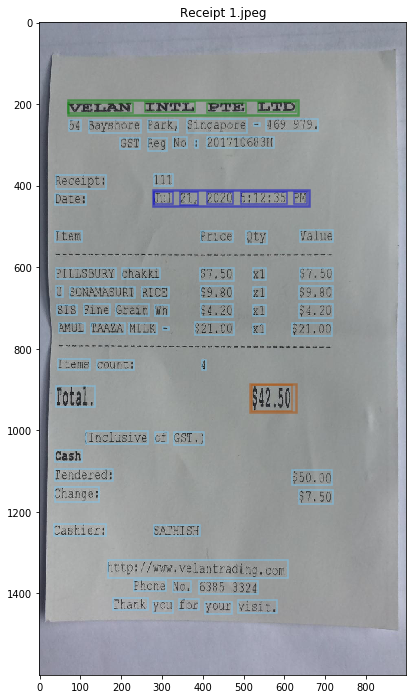

Page: BoundingBox: width: 0.5237860083580017, height: 0.9296336770057678, left: 0.23263145983219147, top: 0.010748994536697865



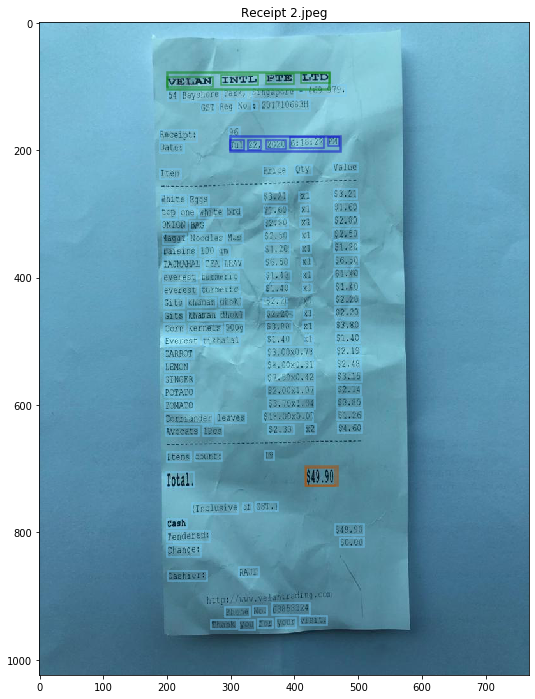

Page: BoundingBox: width: 0.7508724331855774, height: 0.9359787702560425, left: 0.12794524431228638, top: 0.03641799837350845



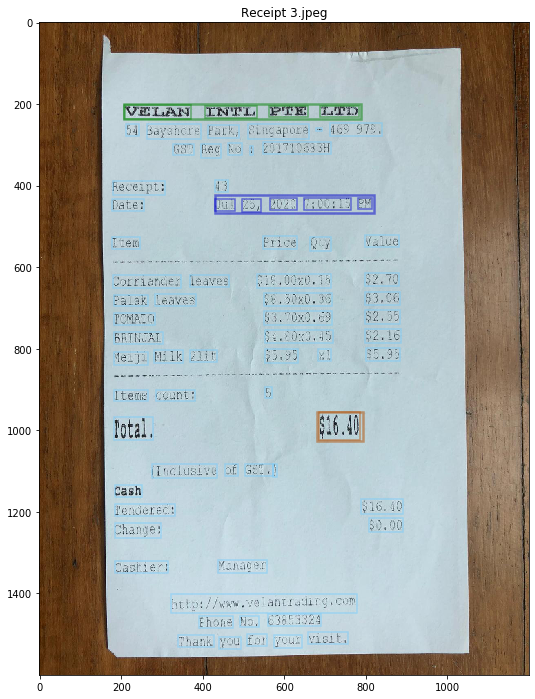

Page: BoundingBox: width: 0.9166730642318726, height: 0.8813958168029785, left: 0.02367856726050377, top: 0.07294296473264694



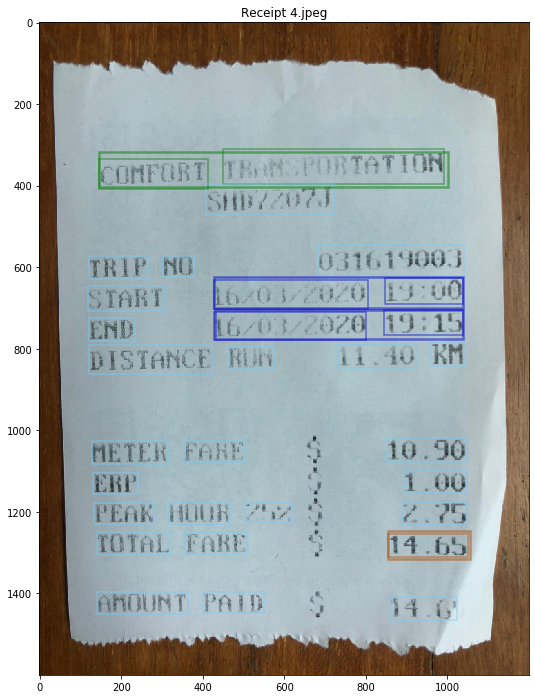

Page: BoundingBox: width: 0.6647153496742249, height: 0.9338748455047607, left: 0.156598761677742, top: 0.016665834933519363



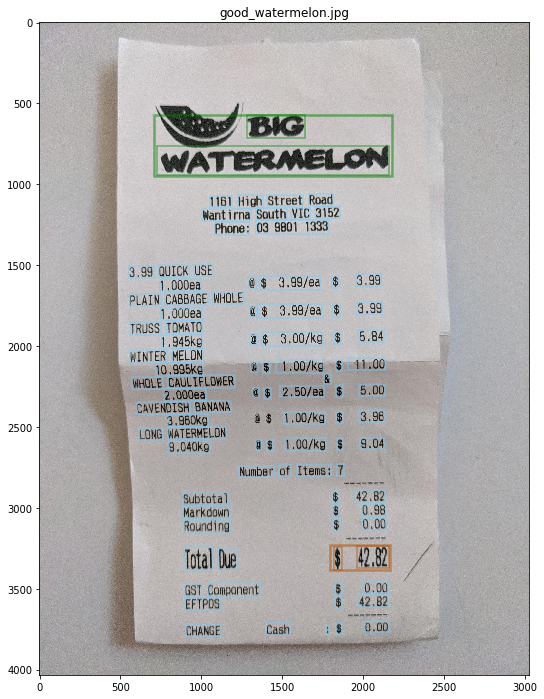

Page: BoundingBox: width: 1.0, height: 1.0, left: 0.0, top: 0.0



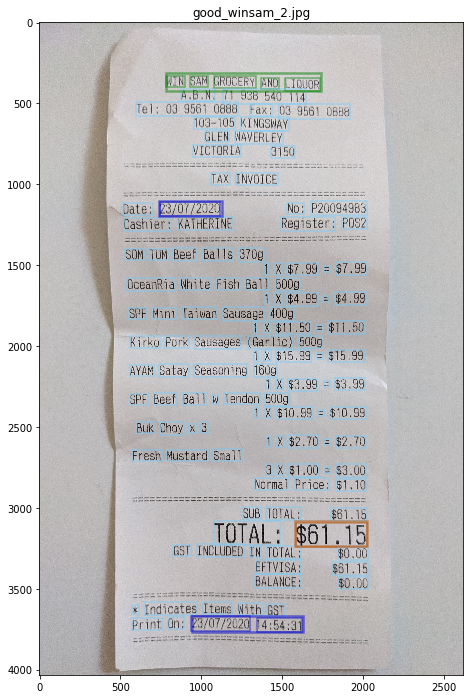

In [78]:
def draw_smgt_annotated_page(
    img_path,
    ann_classes=[
        SimpleNamespace(name="Vendor", color=(0., .5, 0., 0.5)),
        SimpleNamespace(name="Date", color=(0., 0., 0.8, 0.5)),
        SimpleNamespace(name="Amount", color=(0.7, 0.3, 0., 0.5)),
    ],
    annotations=[],
    textract_path=None,
    plain_color=(0.45, 0.8, 1, 0.5),
    err_color=(1., 0., 0., 0.7),
    figsize=(12, 12),
):
    fig = plt.figure(figsize=figsize)
    img = PIL.Image.open(img_path)
    plt.imshow(img)
    ax = fig.axes[0]
    ax.set_title(img_path.rpartition("/")[2])
    
    if textract_path is not None:
        with open(textract_path, "r") as ftextract:
            textract_result = trp.Document(json.loads(ftextract.read()))
        page = textract_result.pages[0]
        print(f"Page: {str(page.geometry)}")
        
        for line in page.lines:
            for word in line.words:
                word_box = word.geometry.boundingBox
                abs_word_left = word_box.left * img.width
                abs_word_top = word_box.top * img.height
                abs_word_width = word_box.width * img.width
                abs_word_height = word_box.height * img.height
                abs_word_area = abs_word_width * abs_word_height
                matched_annotations = []
                for ann in annotations:
                    isect_left = max(abs_word_left, ann["left"])
                    isect_top = max(abs_word_top, ann["top"])
                    isect_right = min(
                        abs_word_left + abs_word_width,
                        ann["left"] + ann["width"],
                    )
                    isect_bottom = min(
                        abs_word_top + abs_word_height,
                        ann["top"] + ann["height"],
                    )
                    isect_area = (
                        max(0, isect_right - isect_left)
                        * max(0, isect_bottom - isect_top)
                    )
                    if isect_area >= (abs_word_area / 2):
                        matched_annotations.append(ann)
            
                if len(matched_annotations) > 1:
                    word_color = err_color
                    print("ERROR: Word matched multiple annotations")
                    print(str(word_box))
                    print(matched_annotations)
                elif len(matched_annotations) > 0:
                    word_color = ann_classes[matched_annotations[0]["class_id"]].color
                else:
                    word_color = plain_color
                
                word_rect = plt.Rectangle(
                    (word_box.left * img.width, word_box.top * img.height),
                    word_box.width * img.width, word_box.height * img.height,
                    fill=False,
                    edgecolor=word_color,#(0.35, 0.7, 1., 0.5),
                    linewidth=1.5,
                )
                ax.add_patch(word_rect)
        
    for ann in annotations:
        ann_rect = plt.Rectangle(
            (ann["left"], ann["top"]),
            ann["width"], ann["height"],
            fill=False,
            edgecolor=ann_classes[ann["class_id"]].color,
            linewidth=2.5,
        )
        ax.add_patch(ann_rect)
    plt.show()

def draw_from_manifest_item(item, ann_field_name):
    ann_result = item[ann_field_name]
    img_s3uri = item["source-ref"]
    img_s3bucket, _, img_s3key = img_s3uri[len("s3://"):].partition("/")
    img_path = "data" + img_s3key[len(prefix):]
    textract_s3uri = item.get("textract-ref")
    if textract_s3uri:
        textract_s3bucket, _, textract_s3key = textract_s3uri[len("s3://"):].partition("/")
        textract_path = "data" + textract_s3key[len(prefix):]
    else:
        textract_path = None

    draw_smgt_annotated_page(
        img_path,
        ann_classes=[
            SimpleNamespace(name="Vendor", color=(0., .5, 0., 0.5)),
            SimpleNamespace(name="Date", color=(0., 0., 0.8, 0.5)),
            SimpleNamespace(name="Amount", color=(0.7, 0.3, 0., 0.5)),
        ],
        annotations=ann_result["annotations"],
        textract_path=textract_path,
        plain_color=(0.45, 0.8, 1, 0.5),
        err_color=(1., 0., 0., 0.7),
        figsize=(12, 12),
    )

with open("./data/combined.manifest.jsonl", "r") as fcombined:
    for ix, item_str in enumerate(fcombined):
        item = json.loads(item_str)
        draw_from_manifest_item(item, "receipts-boxes-1")
        if ix >= 5:
            break

### Train/Validation Split

In [122]:
def split_manifest_stratified(manifest_path, out_path_train=None, out_path_val=None, out_path_test=None, val_ratio=0.15, test_ratio=0.15):
    items_by_cat = defaultdict(list)
    with open(manifest_path, "r") as finput:
        for line in finput:
            item = json.loads(line)
            cat = item["source-ref"][len("s3://"):].partition("/")[2].rpartition("/")[0]
            items_by_cat[cat].append(item)
        items = [json.loads(line) for line in finput]

    item_counts_by_cat = { cat: len(items_by_cat[cat]) for cat in items_by_cat }
    print(f"Got {len(item_counts_by_cat)} categories with record counts:")
    print(pd.Series(item_counts_by_cat).sort_values(ascending=False).head())
    print()

    train = []
    val = []
    test = []
    for cat in sorted(items_by_cat.keys()):
        new_items = items_by_cat[cat]
        random.shuffle(new_items)
        n_batch = len(new_items)
        print(f"Processing {cat} ({n_batch} items)")
        n_train_curr = len(train)
        n_val_curr = len(val)
        n_test_curr = len(test)
        n_total_next = n_train_curr + n_val_curr + n_test_curr + n_batch
        n_val_target = n_total_next * val_ratio
        n_test_target = n_total_next * test_ratio
        n_train_target = n_total_next - n_val_target - n_test_target
        n_test_samples = round(n_test_target - n_test_curr)
        test += new_items[:n_test_samples]
        n_val_samples = round(n_val_target - n_val_curr)
        val += new_items[n_test_samples:(n_test_samples + n_val_samples)]
        train += new_items[(n_test_samples + n_val_samples):]

        print(f"Tracking: {len(train)/n_total_next}, {len(val)/n_total_next}, {len(test)/n_total_next}")
    print()

    random.shuffle(train)
    random.shuffle(val)
    random.shuffle(test)

    for path, items in zip(
        (out_path_train, out_path_val, out_path_test),
        (train, val, test)
    ):
        if path:
            with open(path, "w") as f:
                for ix, item in enumerate(items):
                    f.write(
                        ("\n" if ix > 0 else "")
                        + json.dumps(item)
                    )
            print(f"Wrote {len(items)} records to {path}")

    return train, val, test


train, val, test = split_manifest_stratified(
    "./data/combined.manifest.jsonl",
    "./data/combined-train.manifest.jsonl",
    "./data/combined-val.manifest.jsonl",
    "./data/combined-test.manifest.jsonl",
    val_ratio=0.15,
    test_ratio=0.15,
)


Got 3 categories with record counts:
receipts/images-cleaned/original             347
receipts/images-cleaned/custom/good           19
receipts/images-cleaned/custom/borderline      6
dtype: int64

Processing receipts/images-cleaned/custom/borderline (6 items)
Tracking: 0.6666666666666666, 0.16666666666666666, 0.16666666666666666
Processing receipts/images-cleaned/custom/good (19 items)
Tracking: 0.68, 0.16, 0.16
Processing receipts/images-cleaned/original (347 items)
Tracking: 0.6989247311827957, 0.15053763440860216, 0.15053763440860216

Wrote 260 records to ./data/combined-train.manifest.jsonl
Wrote 56 records to ./data/combined-val.manifest.jsonl
Wrote 56 records to ./data/combined-test.manifest.jsonl


In [126]:
for path in (
    "data/combined-train.manifest.jsonl",
    "data/combined-val.manifest.jsonl",
    "data/combined-test.manifest.jsonl",
):
    key = prefix + path[len("data"):]
    bucket.Object(key).upload_file(path)
    print(f"Uploaded s3://{bucket_name}/{key}")

Uploaded s3://textract-layoutlm-test-thewsey/receipts/combined-train.manifest.jsonl
Uploaded s3://textract-layoutlm-test-thewsey/receipts/combined-val.manifest.jsonl
Uploaded s3://textract-layoutlm-test-thewsey/receipts/combined-test.manifest.jsonl


## Model Training

In [10]:
from sagemaker.pytorch import PyTorch as PyTorchEstimator, PyTorchModel

In [82]:
hyperparameters = {
    "annotation-attr": "receipts-boxes-1",
    "textract-prefix": textract_clean_prefix,
    "num-labels": 4,
    "max-seq-len": 512,
    "learning-rate": 1e-6,
    "max-epochs": 10,
}

estimator = PyTorchEstimator(
    role=role,
    entry_point="train.py",
    source_dir="src",
    framework_version="1.6",
    py_version="py3",

    base_job_name="layoutlm-receipts",
    output_path=f"s3://{bucket_name}/{prefix}/trainjobs",
    #checkpoint_s3_uri=f"s3://{bucket_name}/{prefix}/trainjobs",  # Checkpointing not yet implemented

    debugger_hook_config=False,

    instance_count=1,
    instance_type="ml.p3.2xlarge",
    hyperparameters=hyperparameters,
    metric_definitions=[
        # One console log per output e.g.:
        # 2021-02-13 16:16:00,930 [root] INFO Epoch 6 Metrics: train.n_examples=261; train.loss_avg=0.05200725048780441;
        # validation.n_examples=56; validation.loss_avg=0.0451819269385721; validation.acc=0.9711982011795044;
        # validation.focus_acc=0.7264231443405151;
        # ...So extract metrics with regex as follows:
        { "Name": "train.n_examples", "Regex": r"Epoch \d.* train.n_examples=(.*?);" },
        { "Name": "train.loss_avg", "Regex": r"Epoch \d.* train.loss_avg=(.*?);" },
        { "Name": "validation.n_examples", "Regex": r"Epoch \d.* validation.n_examples=(.*?);" },
        { "Name": "validation.loss_avg", "Regex": r"Epoch \d.* validation.loss_avg=(.*?);" },
        { "Name": "validation.acc", "Regex": r"Epoch \d.* validation.acc=(.*?);" },
        { "Name": "validation.focus_acc", "Regex": r"Epoch \d.* validation.focus_acc=(.*?);" },
    ],
    enable_sagemaker_metrics=True,
    profiler_config=sagemaker.debugger.ProfilerConfig(
        framework_profile_params=sagemaker.debugger.FrameworkProfile(),
    ),
)

In [83]:
estimator.fit(
    inputs={
        "train": f"s3://{bucket_name}/{prefix}/combined-train.manifest.jsonl",
        "textract": f"s3://{bucket_name}/{textract_clean_prefix}/",
        "validation": f"s3://{bucket_name}/{prefix}/combined-val.manifest.jsonl",
    },
    #wait=False,
)

2021-02-15 16:27:05 Starting - Starting the training job...
2021-02-15 16:27:28 Starting - Launching requested ML instancesProfilerReport-1613406424: InProgress
......
2021-02-15 16:28:29 Starting - Preparing the instances for training......
2021-02-15 16:29:30 Downloading - Downloading input data...
2021-02-15 16:29:57 Training - Downloading the training image......
2021-02-15 16:30:53 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-02-15 16:30:53,841 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2021-02-15 16:30:53,867 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-02-15 16:30:53,874 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-02-15 16:30:54,246 sagemaker-training-toolkit INFO     Installing dependencies from requirements.

## Model Deployment (via PyTorchModel)

In [84]:
training_job_desc = estimator.latest_training_job.describe()
model_path = training_job_desc["ModelArtifacts"]["S3ModelArtifacts"]
model_name = training_job_desc["TrainingJobName"]

In [89]:
try:
    model.delete_model()
    print("Deleted model")
    time.sleep(2)
except (AttributeError, NameError, ValueError):
    # AttributeError: Model() wasn't initialized with a sagemaker_session and hasn't created one yet
    # NameError: model hasn't been defined yet
    # ValueError: Current model isn't saved to SageMaker
    pass
except botoexceptions.ClientError as e:
    if (
        e.response["Error"]["Code"] == "ValidationException"
        and e.response["Error"]["Message"].startswith("Could not find")
    ):
        # SDK tried to delete but model wasn't found
        pass
    else:
        raise e

# Note a SageMaker SDK "Model" isn't strictly backed by a SageMaker API "Model": The Model only gets created
# when .transformer() or .deploy() are called... So we can't apply tags at the point of SDK "Model" creation
# or load an SDK "Model" from an API Model name/ARN.
model = PyTorchModel(
    name=model_name,
    model_data=model_path,
    role=role,
    source_dir="src/",
    entry_point="src/inference.py",
    framework_version="1.6",
    py_version="py3",
    env={
        "PYTHONUNBUFFERED": "1",
    }
    #sagemaker_session=smsess,
)

In [90]:
try:
    predictor.delete_endpoint(delete_endpoint_config=True)
    print("Deleted endpoint")
    time.sleep(5)  # (Otherwise can trigger ResourceLimitExceeded if creating again immediately)
except:
    pass

predictor = model.deploy(
    endpoint_name=model.name,  # Use model.name to avoid us accidentally deploying the model twice
    initial_instance_count=1,
    instance_type="ml.g4dn.xlarge",
    #wait=False,
)
predictor.serializer = sagemaker.serializers.JSONSerializer()
predictor.deserializer = sagemaker.deserializers.JSONDeserializer()

Deleted endpoint
---------------!

## Alternative Deployment (Direct from Estimator)

In [73]:
# Test for direct deployment:
training_job_desc = estimator.latest_training_job.describe()
predictor = estimator.deploy(
    endpoint_name=training_job_desc["TrainingJobName"],
    initial_instance_count=1,
    instance_type="ml.g4dn.xlarge",
    env={
        "PYTHONUNBUFFERED": "1",
        #"SAGEMAKER_PROGRAM": "inference.py",  # This line seems ignored anyway, hence the train.py fix
    }
)
predictor.serializer = sagemaker.serializers.JSONSerializer()
predictor.deserializer = sagemaker.deserializers.JSONDeserializer()

---------------!

## Alternative Local Training

Since SageMaker Studio does not currently support [Local Mode](https://aws.amazon.com/blogs/machine-learning/use-the-amazon-sagemaker-local-mode-to-train-on-your-notebook-instance/), we'll use CLI to locally test our training script something like the below.

(This will require running on a kernel with PyTorch installed, e.g. PyTorch 1.6 / Python 3.6 GPU Optimized for example)

In [ ]:
%%sh

mkdir -p data/model-local
mkdir -p data/output-local

python3 src/train.py \
    --train data/combined-train.manifest.jsonl \
    --validation data/combined-val.manifest.jsonl \
    --textract data/textract-results-clean \
    --annotation-attr receipts-boxes-1 \
    --textract-prefix receipts/textract-results-clean/ \
    --model-dir data/model-local \
    --output-data-dir data/output-local \
    --num-labels 4 \
    --max-seq-len 512 \
    --learning-rate 1e-6 \
    --max-epochs 10

## Use the Model

In [91]:
with open("data/textract-results-clean/custom/borderline/Receipt 1-jpeg-response.json", "r") as f:
#with open("data/textract-results-clean/custom/good/20200718_192137_nototal_wrongvendor-jpg-response.json", "r") as f:
    result_json = predictor.predict(json.loads(f.read()))
    result_trp = trp.Document(result_json)

for page_num, page in enumerate(result_trp.pages, start=1):
    print(f"\nPage {page_num}\n-------")
    active_cls = None
    active_text = ""
    class_names = ["E-VND", "E-DAT", "E-AMT", "O-OOO"]
    for line in page.lines:
        for word in line.words:
            if word.block["PredictedClass"] == active_cls:
                active_text += (" " + word.text)
            else:
                if active_cls not in (None, 3):
                    print(f"{class_names[active_cls]}: {active_text}")
                active_text = word.text
                active_cls = word.block["PredictedClass"]
    if active_cls not in (None, 3):
        print(f"{active_cls}: {active_text}")
        active_text = word.text
        active_cls = word.block["PredictedClass"]


Page 1
-------
E-VND: VELAN INTL PTE LTD
E-DAT: Jul 21, 2020 5:12:35 PM


## Observations

Not perfect, and struggles in particular to pick up the 'amount' field... But overall pretty good!

## Clean Up

In [ ]:
predictor.delete_endpoint(delete_endpoint_config=True)

In [ ]:
model.delete_model()